In [1]:
import os
import numpy as np
import cv2
import json
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import albumentations as A
import torchvision.transforms as T

from torch.utils.data import DataLoader
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers.integrations import MLflowCallback
from PIL import Image
from PIL import ImageOps
from matplotlib import pyplot as plt
from matplotlib import patches as patches
from typing import Dict, List, Tuple
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from albumentations.pytorch import ToTensorV2

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*copying from a non-meta parameter.*")

In [3]:
def draw_boxes(image, boxes: list, labels: list = None, figsize = (12, 8), max_label_width=20):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x_min, y_min, width, height = box
        start = (x_min, y_min)
        rect = patches.Rectangle(
            xy=start,
            width=width,
            height=height,
            linewidth=2,
            edgecolor='r',
            facecolor='none'
        )
        ax.add_patch(rect)

        # Draw label if provided
        if labels and i < len(labels):
            label = labels[i]
            wrapped_label = '\n'.join(textwrap.wrap(label, width=max_label_width))

            # Adjust Y so label doesn't go above image
            label_y = y_min - 10
            if label_y < 0:
                label_y = y_min + 10

            # label_y = label_y + randint(0, 100)

            ax.text(
                x_min,
                label_y,
                wrapped_label,
                fontsize=9,
                color='white',
                verticalalignment='top',
                bbox=dict(facecolor='red', alpha=0.7, pad=2)
            )

    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def random_zoom_crop(image, zoom_factor=None, max_size=1200, center_mode='random'):
    """
    Crop and resize an image with specified zoom factor and center mode.

    Args:
        image: Input image array
        zoom_factor: Factor to zoom in (>1 zooms in, <1 zooms out). If None, no cropping is performed.
        max_size: Maximum size for the output image
        center_mode: How to position the crop
            - 'random': Random selection from all available options (corners, center, no_crop)
            - 'center': Center the crop on the image
            - 'no_crop': Skip cropping, only resize
            - 'top_left', 'top_right', 'bottom_left', 'bottom_right': Specific corners
            - (x, y): Tuple specifying exact center coordinates

    Returns:
        resized_image: The cropped and resized image
        crop_info: Tuple of (x, y, new_w, new_h, scale) or (0, 0, w, h, scale) if no crop
    """
    h, w = image.shape[:2]

    # If no zoom factor, just resize without cropping
    if zoom_factor is None:
        scale = min(max_size / w, max_size / h)
        resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
        return resized_image, (0, 0, w, h, scale)

    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)

    # Ensure crop dimensions don't exceed image dimensions
    new_h = min(new_h, h)
    new_w = min(new_w, w)

    # Determine crop position based on center_mode
    if center_mode == 'random':
        # Random selection from all available options
        corner = random.choice(['top_left', 'top_right', 'bottom_left', 'bottom_right', 'center'])
        if corner == 'no_crop':
            # No cropping, just resize
            scale = min(max_size / w, max_size / h)
            resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
            return resized_image, (0, 0, w, h, scale)
        elif corner == 'center':
            x = (w - new_w) // 2
            y = (h - new_h) // 2
        elif corner == 'top_left':
            x, y = 0, 0
        elif corner == 'top_right':
            x, y = w - new_w, 0
        elif corner == 'bottom_left':
            x, y = 0, h - new_h
        elif corner == 'bottom_right':
            x, y = w - new_w, h - new_h

    elif center_mode == 'no_crop':
        # No cropping, just resize
        scale = min(max_size / w, max_size / h)
        resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
        return resized_image, (0, 0, w, h, scale)

    elif center_mode == 'center':
        # Center the crop
        x = (w - new_w) // 2
        y = (h - new_h) // 2

    elif center_mode in ['top_left', 'top_right', 'bottom_left', 'bottom_right']:
        # Specific corner
        if center_mode == 'top_left':
            x, y = 0, 0
        elif center_mode == 'top_right':
            x, y = w - new_w, 0
        elif center_mode == 'bottom_left':
            x, y = 0, h - new_h
        elif center_mode == 'bottom_right':
            x, y = w - new_w, h - new_h

    elif isinstance(center_mode, (tuple, list)) and len(center_mode) == 2:
        # Custom center coordinates
        center_x, center_y = center_mode
        x = max(0, min(center_x - new_w // 2, w - new_w))
        y = max(0, min(center_y - new_h // 2, h - new_h))

    else:
        raise ValueError(f"Invalid center_mode: {center_mode}")

    # Crop the image
    cropped_image = image[y:y+new_h, x:x+new_w]

    # Resize the image to max_size
    scale = min(max_size / cropped_image.shape[1], max_size / cropped_image.shape[0])
    resized_image = cv2.resize(cropped_image, (int(cropped_image.shape[1] * scale), int(cropped_image.shape[0] * scale)))

    return resized_image, (x, y, new_w, new_h, scale)

# Function to calculate intersection area between original bbox and crop region
def calculate_intersection_area(bbox, crop_x, crop_y, crop_w, crop_h):
    """Calculate the intersection area between bbox and crop region"""
    bbox_x, bbox_y, bbox_w, bbox_h = bbox

    # Calculate intersection bounds
    x1 = max(bbox_x, crop_x)
    y1 = max(bbox_y, crop_y)
    x2 = min(bbox_x + bbox_w, crop_x + crop_w)
    y2 = min(bbox_y + bbox_h, crop_y + crop_h)

    # If no intersection, return 0
    if x1 >= x2 or y1 >= y2:
        return 0

    return (x2 - x1) * (y2 - y1)

# Function to update bounding boxes and check area ratio
def update_bbox_with_filter(bbox, crop_info, min_ratio=0.3):
    x, y, new_w, new_h, scale = crop_info
    # print(new_w, new_h, scale)
    original_area = bbox[2] * bbox[3]

    # Calculate intersection area with crop region
    intersection_area = calculate_intersection_area(bbox, x, y, new_w, new_h)

    # Check if intersection area meets minimum ratio requirement
    if intersection_area < original_area * min_ratio:
        return None  # Filter out this bbox
    x1 = (bbox[0] - x) * scale
    y1 = (bbox[1] - y) * scale
    x2 = min(x1 + int(bbox[2] * scale), int(new_w * scale) - 10)
    y2 = min(y1 + int(bbox[3] * scale), int(new_h * scale) - 10)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    # Update bbox coordinates
    updated_bbox = [x1, y1, x2 - x1, y2 - y1]

    # Additional check: ensure the updated bbox is still within reasonable bounds
    # and has meaningful dimensions after scaling
    if updated_bbox[2] < 5 or updated_bbox[3] < 5:  # Too small after scaling
        return None

    return updated_bbox

In [12]:
class CocoDataset(torch.utils.data.Dataset):
    """Custom COCO dataset for DETR training"""

    def __init__(self, img_dir: str, annotation_file: str, zoom_factor_range=(1.0, 5.0), min_area_ratio=0.3, transform=None):
        self.img_dir = img_dir
        self.coco = COCO(annotation_file)
        self.zoom_factor_range = zoom_factor_range
        self.min_area_ratio = min_area_ratio
        self.transform = transform
        self.img_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.imgs[img_id]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        zoom_factor = random.uniform(*self.zoom_factor_range)
        zoomed_image, crop_info = random_zoom_crop(image, zoom_factor)
        valid_boxes = []
        fallback_boxes = []

        for ann in anns:
            fallback_boxes.append(ann["bbox"])
            updated_bbox = update_bbox_with_filter(ann['bbox'], crop_info, self.min_area_ratio)
            if updated_bbox is not None:
                valid_boxes.append(updated_bbox)

        if len(valid_boxes) == 0:
            # Revert to the original image and boxes
            zoomed_image = image
            valid_boxes = fallback_boxes

        failsafe_boxes = []
        max_h, max_w = image.shape[:2]
        for box in valid_boxes:
            x, y, w, h = box
            x_max = min(x + w, max_w)
            y_max = min(y + h, max_h)
            x_min = max(x, 0)
            y_min = max(y, 0)

            failsafe_boxes.append([x_min, y_min, x_max - x_min, y_max - y_min])


        if self.transform:
            try:
                transformed = self.transform(image=zoomed_image, bboxes=failsafe_boxes, labels=[0] * len(failsafe_boxes))
                zoomed_image = transformed["image"]
                valid_boxes = transformed["bboxes"]
            except:
                zoomed_image = image
                valid_boxes = fallback_boxes

        return {
            "image": zoomed_image,
            "image_id": img_id,
            "bboxes": valid_boxes
        }

In [13]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5
        ),
        A.Affine(
            shear=(-30, 30),
            fit_output=True,
            p=0.5
        ),
        # Elastic transform for more complex deformations
        A.ElasticTransform(
            alpha=50,
            sigma=5,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5
        )
    ],
    bbox_params=A.BboxParams(
        format="coco",         # COCO format (absolute coords)
        label_fields=["labels"],
        min_area=10,            # filter out too-small boxes
        min_visibility=0.3     # remove boxes with <30% visible area after aug
    ),
)

train_dataset = CocoDataset(
    "/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/train/images",
    "/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/train/annotations_train.json",
    # "/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/val/images",
    # "/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/val/annotations_val.json",
    transform=train_transform
)

/Volumes/Cucumber/Projects/item-identification/.venv/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


loading annotations into memory...
Done (t=2.61s)
creating index...
index created!


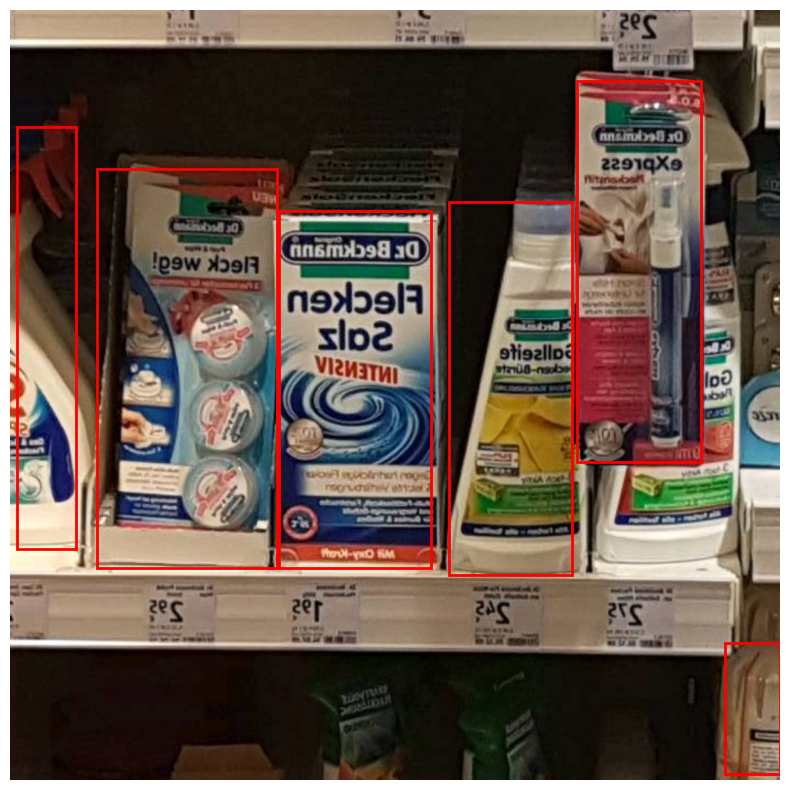

In [7]:
item = train_dataset[0]
draw_boxes(item.get("image"), item.get("bboxes"))

In [8]:
import json
import datetime
import os
from typing import List, Dict, Any, Union
from pathlib import Path
import numpy as np
try:
    from PIL import Image
    PIL_AVAILABLE = True
except ImportError:
    PIL_AVAILABLE = False
    print("Warning: PIL not available. Install with 'pip install Pillow' to save images.")

try:
    import cv2
    CV2_AVAILABLE = True
except ImportError:
    CV2_AVAILABLE = False

class COCOExporter:
    def __init__(self, image_dir: str = "images"):
        """
        Initialize COCO exporter.

        Args:
            image_dir: Directory where images will be saved
        """
        self.annotations = []
        self.images = []
        self.categories = [
            {
                "id": 1,
                "name": "object",
                "supercategory": "object"
            }
        ]
        self.annotation_id = 1
        self.image_id = 1
        self.image_dir = image_dir

        # Create image directory if it doesn't exist
        os.makedirs(image_dir, exist_ok=True)

    def export_to_coco(self, data: List[Dict[str, Any]], output_path: str = "annotations.json",
                      image_format: str = "jpg", image_prefix: str = "img"):
        """
        Export data to COCO format and save images.

        Args:
            data: List of dictionaries containing 'image' (numpy array) and 'bboxes' keys
            output_path: Path to save the COCO annotation file
            image_format: Format to save images ('jpg', 'png')
            image_prefix: Prefix for saved image filenames
        """
        self._reset()

        if not PIL_AVAILABLE and not CV2_AVAILABLE:
            raise ImportError("Either PIL (Pillow) or OpenCV is required to save images. "
                            "Install with 'pip install Pillow' or 'pip install opencv-python'")

        for i, item in enumerate(data):
            self._process_item(item, i, image_format, image_prefix)

        coco_format = {
            "info": {
                "description": "Custom dataset exported to COCO format",
                "url": "",
                "version": "1.0",
                "year": datetime.datetime.now().year,
                "contributor": "COCO Exporter",
                "date_created": datetime.datetime.now().isoformat()
            },
            "licenses": [
                {
                    "id": 1,
                    "name": "Unknown",
                    "url": ""
                }
            ],
            "images": self.images,
            "annotations": self.annotations,
            "categories": self.categories
        }

        # Save annotations to file
        with open(output_path, 'w') as f:
            json.dump(coco_format, f, indent=2)

        print(f"COCO annotations saved to {output_path}")
        print(f"Images saved to {self.image_dir}/")
        print(f"Total images: {len(self.images)}")
        print(f"Total annotations: {len(self.annotations)}")

        return coco_format

    def _reset(self):
        """Reset counters and lists for new export."""
        self.annotations = []
        self.images = []
        self.annotation_id = 1
        self.image_id = 1

    def _process_item(self, item: Dict[str, Any], item_index: int, image_format: str, image_prefix: str):
        """Process a single data item."""
        image_array = item.get('image')
        bboxes = item.get('bboxes', [])

        if image_array is None:
            raise ValueError(f"Item {item_index}: 'image' key is required")

        if not isinstance(image_array, np.ndarray):
            raise ValueError(f"Item {item_index}: 'image' must be a numpy array")

        if len(image_array.shape) != 3 or image_array.shape[2] != 3:
            raise ValueError(f"Item {item_index}: image must be (width, height, 3), got {image_array.shape}")

        # Get image dimensions
        height, width = image_array.shape[:2]  # Note: numpy arrays are (height, width, channels)

        # Generate filename
        filename = f"{image_prefix}_{self.image_id:06d}.{image_format}"
        image_path = os.path.join(self.image_dir, filename)

        # Save image
        self._save_image(image_array, image_path)

        # Create image metadata
        image_dict = {
            "id": self.image_id,
            "width": width,
            "height": height,
            "file_name": filename,
            "license": 1,
            "flickr_url": "",
            "coco_url": "",
            "date_captured": datetime.datetime.now().isoformat()
        }

        self.images.append(image_dict)

        # Process bounding boxes
        for bbox in bboxes:
            annotation = self._create_annotation(bbox, self.image_id)
            self.annotations.append(annotation)

        self.image_id += 1

    def _save_image(self, image_array: np.ndarray, image_path: str):
        """
        Save numpy image array to file.

        Args:
            image_array: Numpy array of shape (height, width, 3)
            image_path: Path where to save the image
        """
        # Ensure image is in correct format (0-255 uint8)
        if image_array.dtype != np.uint8:
            if image_array.max() <= 1.0:
                # Assume image is in 0-1 range, convert to 0-255
                image_array = (image_array * 255).astype(np.uint8)
            else:
                # Assume image is already in 0-255 range but wrong dtype
                image_array = image_array.astype(np.uint8)

        try:
            if PIL_AVAILABLE:
                # Use PIL to save image
                # Convert from numpy (H, W, C) to PIL format
                if image_array.shape[2] == 3:  # RGB
                    pil_image = Image.fromarray(image_array, 'RGB')
                else:
                    pil_image = Image.fromarray(image_array)
                pil_image.save(image_path)
            elif CV2_AVAILABLE:
                # Use OpenCV to save image
                # OpenCV expects BGR, so convert from RGB
                image_bgr = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
                cv2.imwrite(image_path, image_bgr)
            else:
                raise ImportError("No image saving library available")

        except Exception as e:
            raise RuntimeError(f"Failed to save image {image_path}: {str(e)}")

    def _create_annotation(self, bbox: List[float], image_id: int) -> Dict[str, Any]:
        """
        Create a COCO annotation from bbox.

        Args:
            bbox: Bounding box in format [x, y, width, height] or [x_min, y_min, x_max, y_max]
            image_id: ID of the associated image

        Returns:
            COCO annotation dictionary
        """
        if len(bbox) != 4:
            raise ValueError(f"Bbox must have 4 values, got {len(bbox)}")

        # Assume bbox is in [x, y, width, height] format
        # If your bboxes are in [x_min, y_min, x_max, y_max] format, uncomment the lines below:
        # x_min, y_min, x_max, y_max = bbox
        # x, y, width, height = x_min, y_min, x_max - x_min, y_max - y_min

        x, y, width, height = bbox

        annotation = {
            "id": self.annotation_id,
            "image_id": image_id,
            "category_id": 1,  # Always 1 since all objects are "object" class
            "segmentation": [],  # Empty for bounding box only
            "area": width * height,
            "bbox": [x, y, width, height],
            "iscrowd": 0
        }

        self.annotation_id += 1
        return annotation

In [15]:
exporter = COCOExporter(image_dir="/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/transformed/images")
coco_data = exporter.export_to_coco(
    train_dataset,
    output_path="/Volumes/Cucumber/Projects/datasets/raw/s2m-110k/transformed/annotations_transformed.json",
    image_format="jpg",
    image_prefix="transformed"
)

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Premature end of JPEG file
Premature end of JPEG file
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 12658 extraneous bytes before marker 0xd2
Corrupt JPEG data: 102 extraneous bytes before marker 0xd9
Premature end of JPEG file
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 562 extraneous bytes before marker 0xd9
Corrupt JPEG data: 572 extraneous bytes before marker 0xd9
Corrupt JPEG data: 41 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 405 extraneous bytes before marker 0xd9
Corru

COCO annotations saved to /Volumes/Cucumber/Projects/datasets/raw/s2m-110k/transformed/annotations_transformed.json
Images saved to /Volumes/Cucumber/Projects/datasets/raw/s2m-110k/transformed/images/
Total images: 8219
Total annotations: 311618
